# Previsão de Vida Útil (RUL) de Máquinas Industriais

**Autor:** Davi Duarte Cucco

**Objetivo:** Utilizar algoritmos de Regressão para prever o tempo exato de vida útil restante (Remaining Useful Life - RUL) de equipamentos industriais baseando-se em vibração, temperatura e rotação.

**Resultados:**
* **Modelo:** Random Forest Regressor
* **R²:** 0.98 (Alta precisão na explicação da variância)
* **MAE:** ~4.5 horas (Erro médio de previsão)

In [51]:
#importação as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
#Configurações iniciais
np.random.seed(42)
n_amostras = 1000

In [53]:

#Gerar sensores - Variáveis Independentes
#Médias: 70°C, 4mm/s, 1500 RPM
temperatura = np.random.normal(70,15,n_amostras) #(media,dp,vetor)
vibracao = np.random.normal(4,2,n_amostras)
rotacao = np.random.normal(1500,200,n_amostras)

#Gerar a Vida Útil - Variáveis Dependentes
# Fórmula da "Natureza": Vida Base - Desgaste Térmico - Desgaste Mecânico + Ruído Aleatório
# (Na vida real a gente não sabe essa fórmula, o modelo vai ter que descobrir!)
vida_base = 500 # Uma máquina perfeita duraria 500 horas

#Quanto maior a temperatura e vibração, menor a vida útil
desgaste = (temperatura*2.5) + (vibracao*15) + (rotacao*0.05)
horas_ate_falha = 500 - desgaste

#Adição de um erro aleatório, pois os números não serão perfeitos no mundo real
#Caos proposital
ruido = np.random.normal(0,15,n_amostras)

#Garantia de que não haja "horas negativas"
#Quando chegou em 0, significa que a máquina quebrou
horas_ate_falha = np.clip(horas_ate_falha,0,None)

#Vetores criados, organizamos todos eles dentro de um DataFrame
df = pd.DataFrame({
    'temperatura': temperatura,
    'vibracao': vibracao,
    'rotacao': rotacao,
    'RUL_horas': horas_ate_falha #O alvo desse projeto será esse (Target)
})

print("--- AMOSTRA DE DADOS DE REGRESSÃO ---")
display(df.head()) #Mostrar nosso DataFrame

print("\nEstatisticas do Tempo de Vida (RUl):")
print(df['RUL_horas'].describe)


--- AMOSTRA DE DADOS DE REGRESSÃO ---


,temperatura,vibracao,rotacao,RUL_horas
0,77.450712,6.798711,1364.964345,136.144339
1,67.926035,5.849267,1471.096266,168.891088
2,79.715328,4.119261,1341.516016,171.846968
3,92.845448,2.706126,1438.407694,155.374099
4,66.487699,5.396447,1121.277067,196.770199



Estatisticas do Tempo de Vida (RUl):
<bound method NDFrame.describe of 0      136.144339
1      168.891088
2      171.846968
3      155.374099
4      196.770199
          ...    
995    167.661949
996    120.804868
997    204.842238
998    212.969457
999    192.427816
Name: RUL_horas, Length: 1000, dtype: float64>


Desta forma, os dados com os quais vamos trabalhar neste exemplo estão prontos.

O primeiro passo para isso é responder: existe uma relação matemática visísel entre o sensor e a vida útil?

Coeficiente de Pearson vai dar esta resposta através do Mapa de Calor


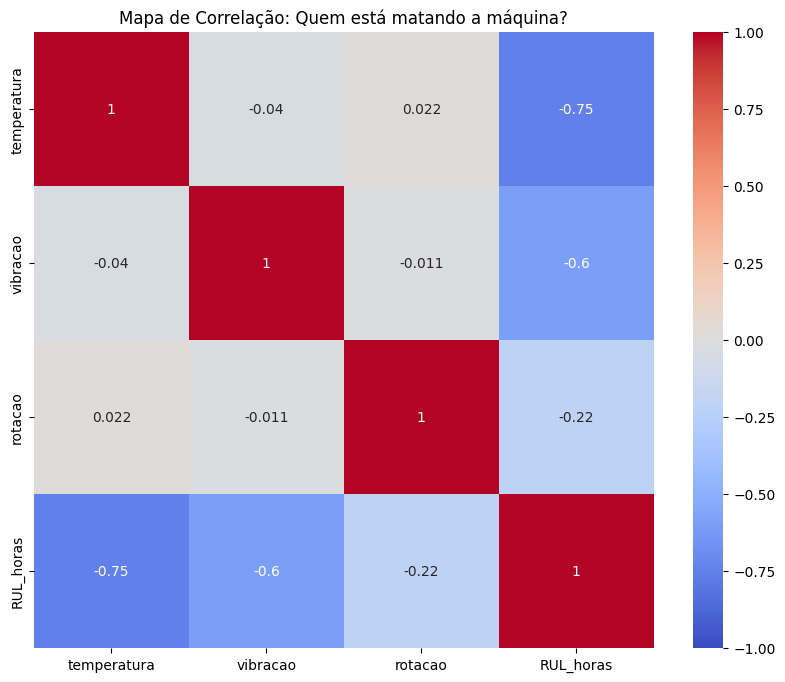

In [54]:
correlacao = df.corr() #Matriz de Correlação

#Plotar Mapa de Calor
plt.figure(figsize=(10,8))
sns.heatmap(correlacao,annot=True,cmap='coolwarm',vmin=-1,vmax=1)
plt.title('Mapa de Correlação: Quem está matando a máquina?')
plt.show()


O Mapa já mostra claramente que, com o aumento da vibração e da temperatura, a vida útil da máquina diminui.


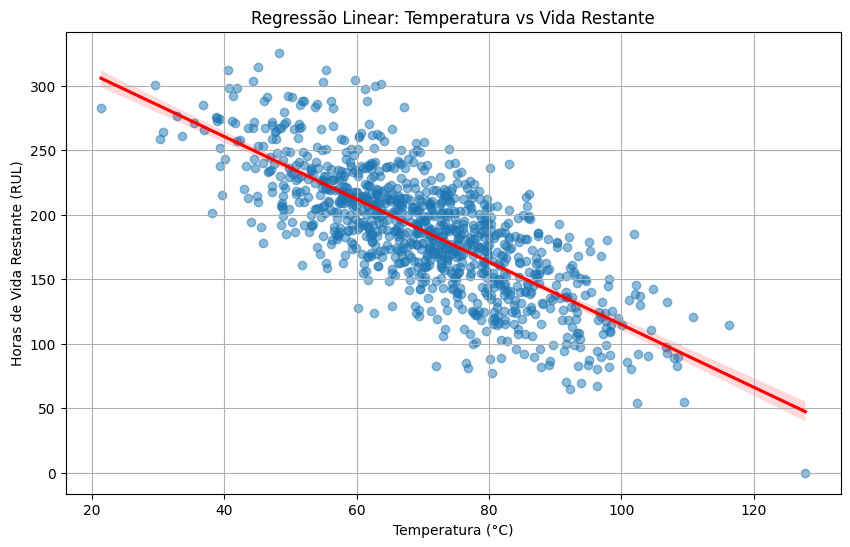

In [55]:
#Plotanto agora a Regressão Linear (Temperatura com RUL)
plt.figure(figsize=(10,6))
sns.regplot(x='temperatura',y='RUL_horas',data=df,scatter_kws={'alpha':0.5},line_kws={'color':'red'})
plt.title('Regressão Linear: Temperatura vs Vida Restante')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Horas de Vida Restante (RUL)')
plt.grid(True)
plt.show()

A correlação é forte e é certo que a temperatura (e a vibração também) tem forte impacto na diminuição da Vida Útil das máquinas.

Agora, é necessário que haja a availação do ERRO.

MAE: "em média, de quanto é o erro?"

R²: o quanto o modelo representa a realidade e a variabilidade dos dados.

In [56]:
#Puxar as ferramentas necessárias das libs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [57]:
x = df[['temperatura','vibracao', 'rotacao']] #Sensores
y = df['RUL_horas'] #Horas Restantes

#Dividir 70% Treino e 30% Teste
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)

#Criar e treinar o modelo
modelo_regressao = RandomForestRegressor(n_estimators=100,random_state=42)
modelo_regressao.fit(x_train,y_train)

RandomForestRegressor(random_state=42)

In [58]:
#Previsões
previsoes = modelo_regressao.predict(x_test)

#Avaliar desempenho do modeelo
mae = mean_absolute_error(y_test,previsoes)
rmse = np.sqrt(mean_squared_error(y_test,previsoes))
r2 = r2_score(y_test,previsoes)

In [59]:
#Mostrar resultados da análise de desempenho do modelo
print(f"--- RELATÓRIO DE DESEMPENHO (REGRESSÃO) ---")
print(f"\nErro Médio Absoluto (MAE): {mae:.2f} horas")
print(f"\nRaiz do Erro Quadrático Médio (RMSE): {rmse:.2f} horas")
print(f"\nCoeficiente R²: {r2:.2f} (Quanto mais perto de 1.0, melhor)")

--- RELATÓRIO DE DESEMPENHO (REGRESSÃO) ---

Erro Médio Absoluto (MAE): 4.47 horas

Raiz do Erro Quadrático Médio (RMSE): 6.96 horas

Coeficiente R²: 0.98 (Quanto mais perto de 1.0, melhor)


Se o R² der acima de 0.90 (deu 0.98), seu modelo é um gênio da matemática. Se o MAE deu as 4.47 horas, significa que ele consegue prever quando a máquina vai quebrar com uma margem de erro de apenas 4.47 horas. Isso para a indústria é ouro!

<function matplotlib.pyplot.show(close=None, block=None)>

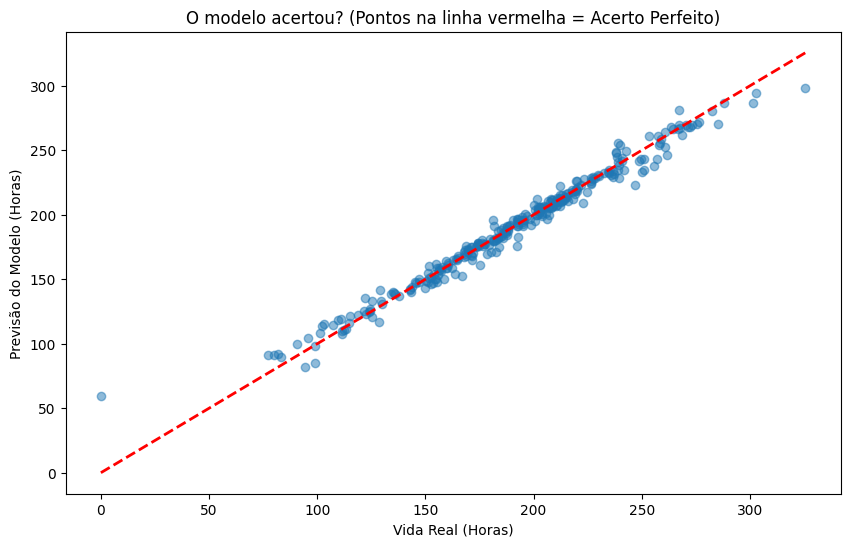

In [60]:
#Plotar um gráfico para representar as diferenças entre a Realidade e a Previsão
plt.figure(figsize=(10,6))
plt.scatter(y_test,previsoes,alpha=0.5)
plt.plot([y.min(),y.max()], [y.min(),y.max()],'r--',lw=2) #Representação da linha perfeita
plt.xlabel('Vida Real (Horas)')
plt.ylabel('Previsão do Modelo (Horas)')
plt.title('O modelo acertou? (Pontos na linha vermelha = Acerto Perfeito)')
plt.show

R² = 0.98: O modelo entendeu 98% do comportamento da máquina. Basicamente, ele "descobriu" a fórmula física de desgaste que criada no início, apenas observando os dados. Qualquer coisa acima de 0.80 já é considerada uma correlação fortíssima.

MAE = 4.47 horas: Esse é o dado **mais importante** para o chão de fábrica. Significa que, quando o modelo diz "Vai quebrar em 100 horas", a quebra real acontece entre 95.5h e 104.5h.

Impacto: Isso permite que a manutenção marque a parada com uma precisão de ~4 horas. Adeus paradas de emergência na madrugada!

Esse cérebro será salvo a fim de criar uma calculadora de vida útil.

In [61]:
#Salvar Modelo treinado
import joblib
joblib.dump(modelo_regressao,'modelo_RUL_v1.pkl')
print("Modelo de Regressão salvo com sucesso!")
print("-"*50)

Modelo de Regressão salvo com sucesso! 
--------------------------------------------------


In [62]:
#Simulador em Tempo Real
#Funcão para realizar a previsao

def calcular_vida_util(temp,vib,rot):
  modelo = joblib.load('modelo_RUL_v1.pkl') #Carregar modelo treinado

  #Criar dataframe com os dados chegando
  entrada = pd.DataFrame({
      'temperatura': [temp],
      'vibracao': [vib],
      'rotacao': [rot]
  })

  previsao = modelo.predict(entrada)[0]#Realiza a previsão

  return previsao #Retorno da previsão realizada


In [63]:
#Teste do Modelo

#Cenário 1: Máquina Perfeita ("Fria, vibra pouco, rotação normal")
#Máquina Nova
rul_nova = calcular_vida_util(temp=65,vib=2.0,rot=1200)
print(f"Cenário 1 (Máquina Saudável):")
print(f"  Sensores: 65°C | 2.0 mm/s | 1200 RPM")
print(f"  Previsão de Vida Restante: {rul_nova:.1f} horas")
print("-" * 30)

#Cenário 2: Máquina Estressada (Quente, vibrando muito, rotação baixa)
#Máquina Velha
rul_velha = calcular_vida_util(temp=95,vib=8.5,rot=1800)
print(f"Cenário 2 (Máquina Crítica):")
print(f"  Sensores: 95°C | 8.5 mm/s | 1800 RPM")
print(f"  Previsão de Vida Restante: {rul_velha:.1f} horas")


Cenário 1 (Máquina Saudável):
  Sensores: 65°C | 2.0 mm/s | 1200 RPM
  Previsão de Vida Restante: 237.0 horas
------------------------------
Cenário 2 (Máquina Crítica):
  Sensores: 95°C | 8.5 mm/s | 1800 RPM
  Previsão de Vida Restante: 70.1 horas
